In [10]:
# =============================================================================
# 셀 1: 라이브러리 및 기본 설정
# =============================================================================
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from facenet_pytorch import InceptionResnetV1

# 프로젝트 모듈 import
sys.path.append('..')  # 상위 디렉토리(프로젝트 루트) 추가
from src.mtcnn_wrapper import FaceDetector

# 한글 폰트 설정
plt.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


In [11]:
# =============================================================================
# 셀 2: 모델 초기화
# =============================================================================
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"디바이스: {device}")

# 얼굴 탐지기 초기화 (FaceNet용 160x160)
face_detector = FaceDetector(
    image_size=160,
    margin=20,
    prob_threshold=0.9,
    align_faces=True,
    device=device
)

# FaceNet 모델 로드
facenet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

print("✅ 모델 초기화 완료")

디바이스: cuda
Running on device: cuda
✅ 모델 초기화 완료


In [14]:
# =============================================================================
# 셀 3: 타겟 임베딩 로드
# =============================================================================
# 침착맨 임베딩 로드
embedding_path = '../face_recognition/target_embeddings/chimchakman.npy'

if os.path.exists(embedding_path):
    embedding_data = np.load(embedding_path, allow_pickle=True).item()
    target_embedding = torch.tensor(embedding_data['embedding']).to(device)
    
    print("✅ 침착맨 임베딩 로드 성공")
    print(f"   사용된 이미지: {embedding_data['num_images']}개")
    print(f"   생성일시: {embedding_data['generated_at']}")
    print(f"   임베딩 크기: {target_embedding.shape}")
else:
    print(f"❌ 임베딩 파일이 없습니다: {embedding_path}")
    print("   face_recognition/prepare_embeddings.py를 먼저 실행해주세요.")



✅ 침착맨 임베딩 로드 성공
   사용된 이미지: 21개
   생성일시: 2025-06-01T17:56:35.378557
   임베딩 크기: torch.Size([512])


In [16]:
# =============================================================================
# 셀 4: 유틸리티 함수 정의
# =============================================================================
def get_face_embedding(face_image):
    """
    얼굴 이미지에서 임베딩 추출
    
    Args:
        face_image (PIL.Image): 160x160 얼굴 이미지
        
    Returns:
        torch.Tensor: 정규화된 임베딩 벡터
    """
    try:
        # PIL Image를 텐서로 변환
        img_array = np.array(face_image)
        img_tensor = torch.from_numpy(img_array).float().permute(2, 0, 1)
        img_tensor = (img_tensor - 127.5) / 128.0  # 정규화 [-1, 1]
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        # 임베딩 추출
        with torch.no_grad():
            embedding = facenet_model(img_tensor)
            embedding = F.normalize(embedding, p=2, dim=1)  # L2 정규화
        
        return embedding.squeeze()
    
    except Exception as e:
        print(f"임베딩 추출 실패: {e}")
        return None


def calculate_similarity(face_image, target_embedding):
    """
    얼굴 이미지와 타겟 임베딩 간의 유사도 계산
    
    Args:
        face_image (PIL.Image): 얼굴 이미지
        target_embedding (torch.Tensor): 타겟 임베딩
        
    Returns:
        float: 코사인 유사도 (0~1)
    """
    embedding = get_face_embedding(face_image)
    
    if embedding is not None:
        similarity = F.cosine_similarity(embedding.unsqueeze(0), target_embedding.unsqueeze(0))
        return similarity.item()
    
    return 0.0


def test_single_image(image_path, target_embedding, threshold=0.7):
    """
    단일 이미지 테스트
    
    Args:
        image_path (str): 이미지 경로
        target_embedding (torch.Tensor): 타겟 임베딩
        threshold (float): 유사도 임계값
        
    Returns:
        tuple: (원본이미지, 얼굴이미지들, 유사도들, 매칭여부들)
    """
    try:
        # 원본 이미지 로드
        original_img = Image.open(image_path).convert('RGB')
        
        # 얼굴 탐지 및 크롭
        face_images = face_detector.process_image(image_path)
        
        if not face_images:
            return original_img, [], [], []
        
        # 각 얼굴에 대해 유사도 계산
        similarities = []
        matches = []
        
        for face_img in face_images:
            similarity = calculate_similarity(face_img, target_embedding)
            similarities.append(similarity)
            matches.append(similarity > threshold)
        
        return original_img, face_images, similarities, matches
        
    except Exception as e:
        print(f"이미지 테스트 실패 {image_path}: {e}")
        return None, [], [], []

print("✅ 유틸리티 함수 정의 완료")

✅ 유틸리티 함수 정의 완료


📸 참조 이미지 21개로 유사도 분포 확인 중...
  단일 처리: 1개 탐지 → 1개 유효
  ag7.png: 0.427
  단일 처리: 1개 탐지 → 1개 유효
  bg.png: 0.886
  단일 처리: 1개 탐지 → 1개 유효
  bt1.png: 0.733
  단일 처리: 1개 탐지 → 1개 유효
  center.png: 0.871
  단일 처리: 1개 탐지 → 1개 유효
  center2.png: 0.856
  단일 처리: 1개 탐지 → 1개 유효
  center3.png: 0.732
  단일 처리: 1개 탐지 → 1개 유효
  center4.png: 0.874
  단일 처리: 1개 탐지 → 1개 유효
  center5.png: 0.807
  단일 처리: 1개 탐지 → 1개 유효
  center6.jpg: 0.838
  단일 처리: 1개 탐지 → 1개 유효
  center7.png: 0.809
  단일 처리: 1개 탐지 → 1개 유효
  h7.png: 0.754
  단일 처리: 1개 탐지 → 1개 유효
  kd1.png: 0.766
  단일 처리: 1개 탐지 → 1개 유효
  s6.png: 0.756
  단일 처리: 1개 탐지 → 1개 유효
  side.png: 0.904
  단일 처리: 1개 탐지 → 1개 유효
  side2.png: 0.853
  단일 처리: 1개 탐지 → 1개 유효
  side3.png: 0.817
  단일 처리: 1개 탐지 → 1개 유효
  side4.png: 0.871
  단일 처리: 1개 탐지 → 1개 유효
  side5.png: 0.694
  단일 처리: 2개 탐지 → 1개 유효
  side6.png: 0.904
  단일 처리: 1개 탐지 → 1개 유효
  side7.png: 0.810

📊 침착맨 이미지 유사도 통계:
  평균: 0.798
  최소: 0.427
  최대: 0.904
  표준편차: 0.104
  권장 임계값: 0.590


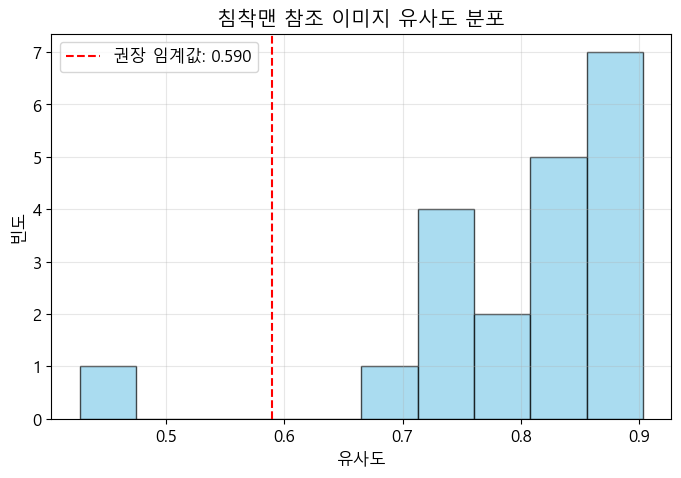

In [19]:
# =============================================================================
# 셀 5: 임계값 튜닝 (참조 이미지 분석)
# =============================================================================
# 침착맨 참조 이미지들로 유사도 분포 확인
reference_dir = '../face_recognition/reference_images/chimchakman'

if os.path.exists(reference_dir):
    ref_files = [f for f in os.listdir(reference_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    ref_similarities = []
    
    print(f"📸 참조 이미지 {len(ref_files)}개로 유사도 분포 확인 중...")
    
    for file_name in ref_files[:20]:  # 최대 10개만
        img_path = os.path.join(reference_dir, file_name)
        _, face_images, similarities, _ = test_single_image(img_path, target_embedding)
        
        if similarities:
            max_sim = max(similarities)  # 가장 높은 유사도
            ref_similarities.append(max_sim)
            print(f"  {file_name}: {max_sim:.3f}")
    
    if ref_similarities:
        print(f"\n📊 침착맨 이미지 유사도 통계:")
        print(f"  평균: {np.mean(ref_similarities):.3f}")
        print(f"  최소: {np.min(ref_similarities):.3f}")
        print(f"  최대: {np.max(ref_similarities):.3f}")
        print(f"  표준편차: {np.std(ref_similarities):.3f}")
        
        # 권장 임계값
        suggested_threshold = np.mean(ref_similarities) - 2 * np.std(ref_similarities)
        suggested_threshold = max(0.5, suggested_threshold)  # 최소 0.5
        print(f"  권장 임계값: {suggested_threshold:.3f}")
        
        # 히스토그램 시각화
        plt.figure(figsize=(8, 5))
        plt.hist(ref_similarities, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(suggested_threshold, color='red', linestyle='--', 
                   label=f'권장 임계값: {suggested_threshold:.3f}')
        plt.xlabel('유사도')
        plt.ylabel('빈도')
        plt.title('침착맨 참조 이미지 유사도 분포')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
else:
    print(f"❌ 참조 이미지 디렉토리가 없습니다: {reference_dir}")
    suggested_threshold = 0.7


In [ ]:
# =============================================================================
# 셀 6: test_image 디렉토리 설정
# =============================================================================
# test_image 디렉토리의 레이블 없는 이미지들 테스트
test_image_dir = r"D:\my_projects\calmman-facial-classification\data\processed\test_image"
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
threshold = 0.7  # 임계값 설정

# 이미지 파일 목록 가져오기
if os.path.exists(test_image_dir):
    test_files = [f for f in os.listdir(test_image_dir) if f.lower().endswith(image_extensions)]
    print(f"📁 test_image 디렉토리에서 {len(test_files)}개 이미지 발견")
else:
    print(f"❌ 디렉토리가 존재하지 않습니다: {test_image_dir}")
    test_files = []

In [20]:
# =============================================================================
# 셀 6: test_image 디렉토리 설정
# =============================================================================
# test_image 디렉토리의 레이블 없는 이미지들 테스트
test_image_dir = r"D:\my_projects\calmman-facial-classification\data\processed\test_image"
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
threshold = 0.7  # 임계값 설정

# 이미지 파일 목록 가져오기
if os.path.exists(test_image_dir):
    test_files = [f for f in os.listdir(test_image_dir) if f.lower().endswith(image_extensions)]
    print(f"📁 test_image 디렉토리에서 {len(test_files)}개 이미지 발견")
else:
    print(f"❌ 디렉토리가 존재하지 않습니다: {test_image_dir}")
    test_files = []

📁 test_image 디렉토리에서 7개 이미지 발견


  단일 처리: 1개 탐지 → 1개 유효
📷 h5.png: 침착맨 ✓ (얼굴 1개, 최대 유사도 0.845)
  단일 처리: 1개 탐지 → 1개 유효
📷 k13.png: 침착맨 ✓ (얼굴 1개, 최대 유사도 0.853)
  단일 처리: 1개 탐지 → 1개 유효
📷 k4.jpeg: 침착맨 ✓ (얼굴 1개, 최대 유사도 0.800)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-05-30 135443.png: 침착맨 ✓ (얼굴 1개, 최대 유사도 0.804)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-05-30 135455_face1.png: 침착맨 ✓ (얼굴 1개, 최대 유사도 0.844)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-05-30 135506.png: 침착맨 ✓ (얼굴 1개, 최대 유사도 0.785)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-05-31 211044.png: 침착맨 ✓ (얼굴 1개, 최대 유사도 0.884)


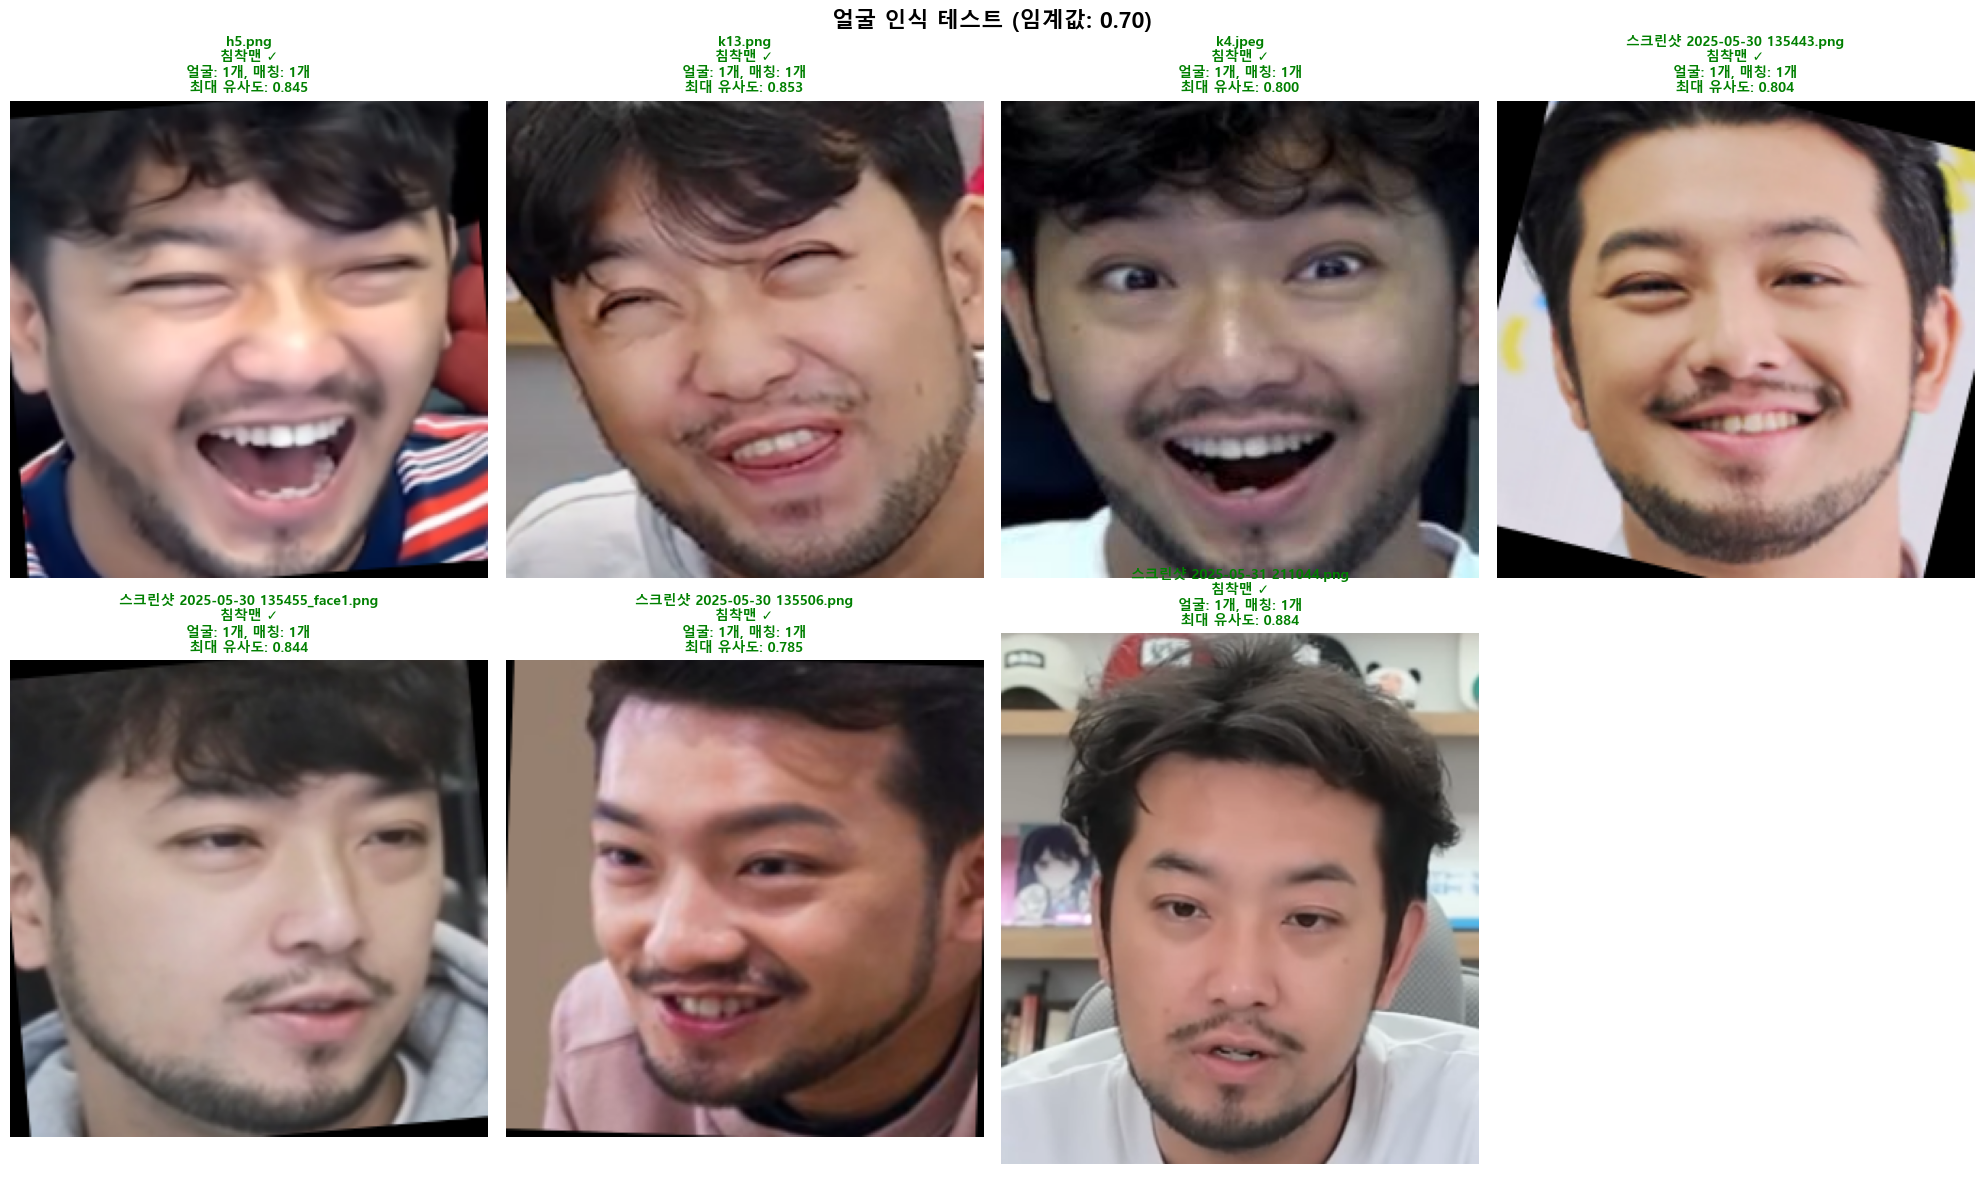

In [21]:
# =============================================================================
# 셀 7: 배치 테스트 시각화
# =============================================================================
if test_files:
    # 최대 8개 이미지 선택
    display_count = min(20, len(test_files))
    selected_files = random.sample(test_files, display_count) if len(test_files) > 8 else test_files
    
    # subplot 설정
    cols = 4
    rows = (display_count + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
    fig.suptitle(f'얼굴 인식 테스트 (임계값: {threshold:.2f})', fontsize=16, fontweight='bold')
    
    # axes 처리
    if rows == 1 and cols > 1:
        axes = axes.reshape(1, -1)
    elif rows > 1 and cols == 1:
        axes = axes.reshape(-1, 1)
    elif rows == 1 and cols == 1:
        axes = [axes]
    axes = np.array(axes).flatten()
    
    # 테스트 결과 저장
    results = []
    
    for idx, file_name in enumerate(selected_files):
        img_path = os.path.join(test_image_dir, file_name)
        
        # 얼굴 인식 테스트
        original_img, face_images, similarities, matches = test_single_image(img_path, target_embedding, threshold)
        
        if original_img is not None:
            # 원본 이미지 표시
            axes[idx].imshow(original_img)
            axes[idx].axis('off')
            
            # 결과 분석
            num_faces = len(face_images)
            num_matches = sum(matches)
            max_similarity = max(similarities) if similarities else 0.0
            
            # 전체 결과 판정
            is_chimchakman = num_matches > 0
            result_color = 'green' if is_chimchakman else 'red'
            result_text = '침착맨 ✓' if is_chimchakman else '다른 사람 ✗'
            
            # 제목 설정
            title = f"{file_name}\n{result_text}\n얼굴: {num_faces}개, 매칭: {num_matches}개\n최대 유사도: {max_similarity:.3f}"
            axes[idx].set_title(title, fontsize=10, color=result_color, fontweight='bold')
            
            # 결과 저장
            results.append({
                'file': file_name,
                'num_faces': num_faces,
                'num_matches': num_matches,
                'max_similarity': max_similarity,
                'is_chimchakman': is_chimchakman,
                'similarities': similarities
            })
            
            print(f"📷 {file_name}: {result_text} (얼굴 {num_faces}개, 최대 유사도 {max_similarity:.3f})")
            
        else:
            axes[idx].text(0.5, 0.5, f'로드 실패\n{file_name}', ha='center', va='center', 
                          transform=axes[idx].transAxes, fontsize=10)
            axes[idx].axis('off')
    
    # 빈 subplot 숨기기
    for idx in range(display_count, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ test_image 디렉토리에 테스트할 이미지가 없습니다.")
    results = []
